In [1]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np

from helper import *

import re
from typing import *

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


### Data Loading

In [2]:
# url = 'https://storage.googleapis.com/tensorflow-1-public/course3/sarcasm.json'

In [3]:
save_path = Path("data/sarcasm/sarcasm.json")

In [4]:
# download_zip_file(url,save_path)

In [5]:
df = pd.read_json(save_path)

In [6]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


In [8]:
df['article_link'][0]

'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5'

In [9]:
def main_name(x):
    return re.findall(r'\.(.*?)\.', x)[0]

In [10]:
df['main_name'] = df['article_link'].apply(main_name)

In [11]:
df.head()

,article_link,headline,is_sarcastic,main_name
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0,huffingtonpost
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0,huffingtonpost
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1,theonion
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1,theonion
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0,huffingtonpost


In [12]:
df['main_name'].value_counts(1)

huffingtonpost    0.561047
theonion          0.438953
Name: main_name, dtype: float64

In [13]:
sentences = df['headline'].to_list()
labels = df['is_sarcastic'].to_list()

In [14]:
sentences[:3], labels[:3]

(["former versace store clerk sues over secret 'black code' for minority shoppers",
  "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  "mom starting to fear son's web series closest thing she will have to grandchild"],
 [0, 0, 1])

### 1.Cleaning the Data

In [15]:
def clean_data(sentences:List):
    ps = PorterStemmer()
    corpus = []
    for i in range(0, len(sentences)):
        each_sentence = re.sub('[^a-zA-Z]', ' ', sentences[i])
        each_sentence = each_sentence.lower()
        each_sentence = each_sentence.split()

        each_sentence = [ps.stem(word)
                         for word in each_sentence if not word in stopwords.words('english')]
        each_sentence = ' '.join(each_sentence)
        corpus.append(each_sentence)
    return corpus

In [16]:
clean_sentences = clean_data(sentences)

In [17]:
clean_sentences[:3]

['former versac store clerk sue secret black code minor shopper',
 'roseann reviv catch thorni polit mood better wors',
 'mom start fear son web seri closest thing grandchild']

### 2.Train test Split

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(
    clean_sentences, labels, test_size=0.20, random_state=0, stratify=labels)

In [19]:
X_train[:3]

['share hazmat suit maker spike nyc ebola news',
 'miss america call u n council promot enough world peac',
 'tarsier world smallest primat anim planet looney front part']

In [20]:
pd.Series(y_train).value_counts(1)

0    0.561052
1    0.438948
dtype: float64

In [21]:
pd.Series(y_test).value_counts(1)

0    0.561026
1    0.438974
dtype: float64

### 3.TensorFlow Embeddings

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 50

# Output dimensions of the Embedding layer
embedding_dim = 16

In [ ]:
X_train[:3]

In [ ]:
# Parameters for padding and OOV tokens
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(
    training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

In [ ]:
training_padded.shape

### With Dense 

In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length,name="embedding"),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(32, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),    
    tf.keras.layers.Dropout(0.3, name="dropout1"),
    
    tf.keras.layers.Dense(16, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.3, name="dropout2"),

    
    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
                                                    monitor='val_loss',
                                                    min_delta=0.0001,
                                                    patience=5,
                                                    verbose=0,
                                                    mode='auto',
                                                    # baseline=None,
                                                    restore_best_weights=True,
                                                    # start_from_epoch=0
                                                )

In [ ]:
num_epochs = 30

# Train the model
history = model.fit(training_padded, 
                    training_labels, 
                    epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels), 
                    verbose=2,
                    callbacks=[early_stopping])

In [ ]:
model.evaluate(testing_padded,testing_labels)

In [ ]:
history.history.keys()

In [ ]:
myDict = history.history

In [ ]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(myDict['loss'])
plt.plot(myDict['val_loss'])
plt.subplot(1,2,2)
plt.plot(myDict['accuracy'])
plt.plot(myDict['val_accuracy'])

### 4.LSTM

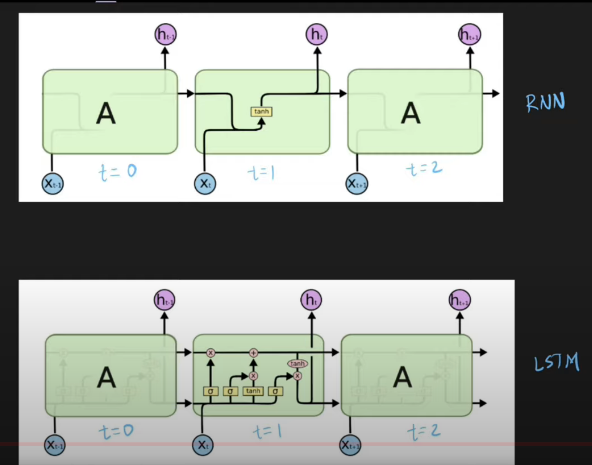

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(3,input_shape=(40,3)),
    tf.keras.layers.Dense(5),
    tf.keras.layers.Dense(2)
])
model.summary()

In [ ]:
# Sending input as 3 rows(each sentence) x 5 columns (embedding vector of each word)
# i have 3 RNN's with 5 vectors of each word weights = 5x3
print(model.get_weights()[0].shape)
model.get_weights()[0]

In [ ]:
# If i use 3 RNN's means it has 3x3 matrix to hold each others input
# the connection between 5 vectors and 3 RNN cells holds 5x3 weights + 3x3 time weights
print(model.get_weights()[1].shape)
model.get_weights()[1]

In [ ]:
# Bias of 3 RNN cells
model.get_weights()[2]

In [ ]:
# weights of RNN cell to dense which is 3
model.get_weights()[3]

In [ ]:
# bias of dense layer
model.get_weights()[4]

In [ ]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(3, input_shape=(3, 5)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

tr_ds = tf.constant(
    [
        [[0, 1, 0, 0, 0], [0, 0, 0, 1, 0], [1, 0, 0, 0, 0]]
    ],
    dtype="float32",
)

# Assuming binary classification, provide corresponding target data
target_data = tf.constant(
    [
        [1]  # 1 indicates a positive class (sarcastic) for the given sequence
    ],
    dtype="float32",
)

model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.01), loss='binary_crossentropy')

model.fit(tr_ds, target_data, epochs=5)

In [ ]:
model.get_weights()[0]

In [ ]:
model.get_weights()[1]

### LSTM on sequences

In [ ]:
training_padded.shape

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((training_padded, training_labels))
train_dataset = (train_dataset
                 .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((testing_padded, testing_labels))
test_dataset = (test_dataset
                 .shuffle(buffer_size=8, reshuffle_each_iteration=True)
                 .batch(32)
                 .prefetch(tf.data.AUTOTUNE))

In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(30, input_shape=(max_length, 1),return_sequences=False, name="LSTM30"),

    # tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),
    tf.keras.layers.Dropout(0.3, name="dropout1"),

    tf.keras.layers.Dense(16, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.3, name="dropout2"),


    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), 
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=30,
          verbose=2,
          callbacks = [early_stopping])

In [ ]:
model.evaluate(test_dataset)

### LSTM with Embeddings

In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length, name="embedding"),
    tf.keras.layers.LSTM(30, name="LSTM30", return_sequences=False),

    # tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),
    tf.keras.layers.Dropout(0.3, name="dropout1"),

    tf.keras.layers.Dense(16, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.3, name="dropout2"),


    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=30,
          verbose=2,
          callbacks=[early_stopping])

### LSTM Embeddings + Bideriectional

In [ ]:
# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length, name="embedding"),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        50, name="LSTM1_50", return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        50, name="LSTM2_50", return_sequences=False)),

    # tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(32, activation='relu', name="dense32"),
    tf.keras.layers.BatchNormalization(name="batch1"),
    tf.keras.layers.Dropout(0.3, name="dropout1"),

    tf.keras.layers.Dense(16, activation='relu', name="dense16"),
    tf.keras.layers.BatchNormalization(name="batch2"),
    tf.keras.layers.Dropout(0.3, name="dropout2"),


    tf.keras.layers.Dense(1, activation='sigmoid', name="last_dense1")
])

# Print the model summary
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

In [ ]:
model.fit(train_dataset,
          validation_data=test_dataset,
          epochs=30,
          verbose=2,
          callbacks=[early_stopping])